In [22]:
from paths import *
import pandas as pd
from model_dataset import Normalizer, DeNormalizer, TokenMap, WordDictionary
import matplotlib.pyplot as plt
import pickle
from torch.utils.data import DataLoader, random_split
from model_dataset import TargetVowelDatasetBoundaryPhoneseqTEST as ThisDataset
from model_dataset import MelSpecTransformDB as TheTransform
from model_dataset import SilenceSampler_for_TV
import torch

In [23]:
REC_SAMPLE_RATE = 16000
N_FFT = 400
N_MELS = 64
BATCH_SIZE = 1
LOADER_WORKER = 32

In [24]:
target_path = src_

In [25]:
t_set = pd.read_csv(os.path.join(target_path, f"phi-T-guide.csv"))
st_set = pd.read_csv(os.path.join(target_path, f"phi-ST-guide.csv"))
integrated = pd.concat([t_set, st_set], ignore_index=True, sort=False)

In [26]:
mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                    n_fft=N_FFT, n_mels=N_MELS, 
                    normalizer=Normalizer.norm_mvn, 
                    denormalizer=DeNormalizer.norm_mvn)

In [134]:
def plot_spectrogram(specgram, title=None, ylabel="freq_bin", ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    # ax.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")

def plot_spectrogram_lined(specgram, title=None, ylabel="freq_bin", ax=None, flines=None, dlines=None, dlines2=None, burstlines=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    if title is not None:
        ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontdict={"fontsize": 18})
    labels = ax.get_xticklabels() + ax.get_yticklabels()
    [label.set_fontsize(18) for label in labels]
    
    ax.imshow(specgram, origin="lower", aspect="auto", interpolation="nearest")
    
    # Draw vertical lines at specified x-values
    if flines is not None:
        for x in flines:
            ax.axvline(x=x, color='red', linestyle='-', linewidth=2)
    if dlines is not None:
        for x in dlines:
            ax.axvline(x=x, color='blue', linestyle='--', linewidth=1)
    if dlines2 is not None:
        for x in dlines2:
            ax.axvline(x=x, color='orange', linestyle='--', linewidth=1)
    if burstlines is not None:
        for x in burstlines:
            ax.axvline(x=x, color='purple', linestyle='dashdot', linewidth=1)

def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, flines=None, dlines=None, dlines2=None, burstlines=None):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sample_rate

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].plot(time_axis, waveform[c], linewidth=1)
        axes[c].grid(True)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
        if xlim:
            axes[c].set_xlim(xlim)
    figure.suptitle(title)
    # Draw vertical lines at specified x-values
    ax = axes[0]
    if flines is not None:
        for x in flines:
            ax.axvline(x=x, color='red', linestyle='-', linewidth=2)
    if dlines is not None:
        for x in dlines:
            ax.axvline(x=x, color='blue', linestyle='--', linewidth=1)
    if dlines2 is not None:
        for x in dlines2:
            ax.axvline(x=x, color='orange', linestyle='--', linewidth=1)
    if burstlines is not None:
        for x in burstlines:
            ax.axvline(x=x, color='purple', linestyle='dashdot', linewidth=1)
    

def frame_to_time(frame_index, sr=16000, hop_length=200):
    return frame_index * hop_length / sr

In [28]:
def get_data_both(rec_dir, t_guide_path, st_guide_path, word_guide_, 
                  noise_controls={"fixlength": False, "amplitude_scale": 0.01}):
    mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                        n_fft=N_FFT, n_mels=N_MELS, 
                        normalizer=Normalizer.norm_mvn, 
                        denormalizer=DeNormalizer.norm_mvn)

    st_valid = pd.read_csv(st_guide_path)
    t_valid = pd.read_csv(t_guide_path)
    # now st also has noise, so we need to sample silence for both
    # st_valid["pre_startTime"] = st_valid["stop_startTime"] - SilenceSampler_for_TV(fixlength=noise_controls["fixlength"]).sample(len(st_valid))
    t_valid["pre_startTime"] = t_valid["stop_startTime"] - SilenceSampler_for_TV(fixlength=noise_controls["fixlength"]).sample(len(t_valid))
    all_valid = pd.concat([t_valid, st_valid], ignore_index=True, sort=False)
    # all_valid.to_csv("all_valid.csv", index=False)
    # raise Exception("Stop here")

    # Load TokenMap to map the phoneme to the index
    with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
        # Load the object from the file
        mylist = pickle.load(file)
        mylist = ["BLANK"] + mylist
        mylist = mylist + ["SIL"]

    # Now you can use the loaded object
    mymap = TokenMap(mylist)

    valid_ds = ThisDataset(rec_dir, 
                        all_valid, 
                        mapper=mymap,
                        transform=mytrans, 
                        hop_length=N_FFT//2, 
                        noise_amplitude_scale=noise_controls["amplitude_scale"])

    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
    return valid_loader

def get_data_both_nost(rec_dir, t_guide_path, st_guide_path, word_guide_, 
                  noise_controls={"fixlength": False, "amplitude_scale": 0.01}):
    mytrans = TheTransform(sample_rate=REC_SAMPLE_RATE, 
                        n_fft=N_FFT, n_mels=N_MELS, 
                        normalizer=Normalizer.norm_mvn, 
                        denormalizer=DeNormalizer.norm_mvn)

    st_valid = pd.read_csv(st_guide_path)
    t_valid = pd.read_csv(t_guide_path)
    # now st also has noise, so we need to sample silence for both
    st_valid["pre_startTime"] = st_valid["stop_startTime"] - SilenceSampler_for_TV(fixlength=noise_controls["fixlength"]).sample(len(st_valid))
    t_valid["pre_startTime"] = t_valid["stop_startTime"] - SilenceSampler_for_TV(fixlength=noise_controls["fixlength"]).sample(len(t_valid))
    all_valid = pd.concat([t_valid, st_valid], ignore_index=True, sort=False)
    # all_valid.to_csv("all_valid.csv", index=False)
    # raise Exception("Stop here")

    # Load TokenMap to map the phoneme to the index
    with open(os.path.join(src_, "no-stress-seg.dict"), "rb") as file:
        # Load the object from the file
        mylist = pickle.load(file)
        mylist = ["BLANK"] + mylist
        mylist = mylist + ["SIL"]

    # Now you can use the loaded object
    mymap = TokenMap(mylist)

    valid_ds = ThisDataset(rec_dir, 
                        all_valid, 
                        mapper=mymap,
                        transform=mytrans, 
                        hop_length=N_FFT//2, 
                        noise_amplitude_scale=noise_controls["amplitude_scale"])

    valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=LOADER_WORKER, collate_fn=ThisDataset.collate_fn)
    return valid_loader

# We want to visualize the proportions taken in ABX calculation. 

In [29]:
check_dir = os.path.join(model_save_, "C_0T-0901104956-5", "guides")

In [30]:
both_loader = get_data_both(train_cut_phone_, os.path.join(check_dir, "T-valid-sampled.csv"), 
                            os.path.join(check_dir, "ST-valid.csv"), None, 
                            noise_controls={"fixlength": False, "amplitude_scale": 5e-4})

WhiteNoiseGen: sample_rate=16000, amplitude_scale=0.0005


Collect the data

In [34]:
all_ze = []
all_zq = []
all_stop_names = []
all_vowel_names = []
all_sepframes1 = []
all_sepframes2 = []
all_attn = []
# all_attn_pp = []
all_recon = []
all_attnout = []
all_ori = []
all_phi_type = []
all_wavs = []

for (x, x_lens, pt, sn, vn, sf1, sf2, phoneseq, wav) in both_loader: 
    ori_x = x.cpu().detach().numpy().squeeze()
    wav = wav[0]
    all_ori += [ori_x]
    all_wavs += [wav]
    all_stop_names += sn
    all_vowel_names += vn
    all_sepframes1 += sf1
    all_sepframes2 += sf2
    all_phi_type += pt

In [35]:
import math
def get_sel_interval(cutstart, cutend, start_offset, end_offset):
    selstart = max(cutstart, math.floor(cutstart + (cutend - cutstart) * start_offset))
    selend = min(cutend, math.ceil(cutstart + (cutend - cutstart) * end_offset))
    return selstart, selend

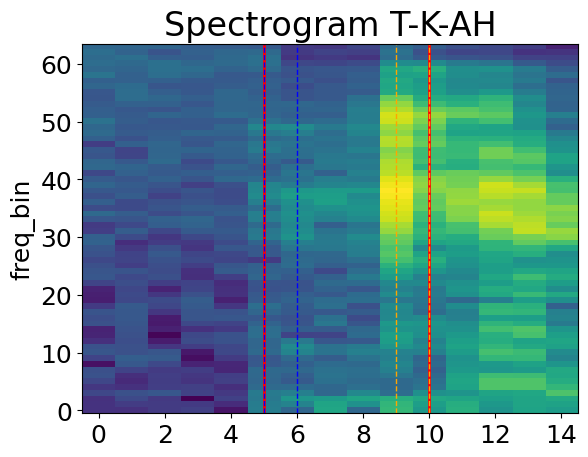

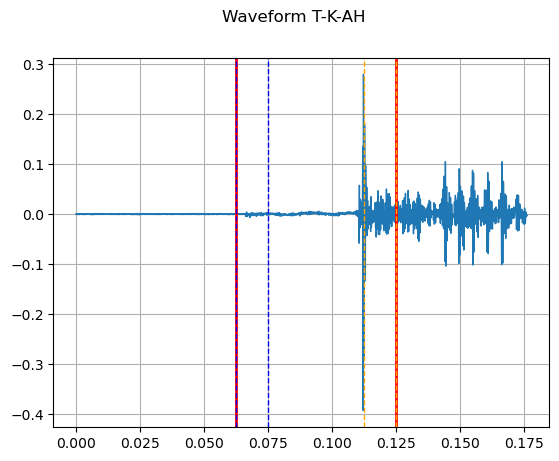

In [92]:
import random
toplotidx = random.randint(0, len(all_ori))

specgram = all_ori[toplotidx]
sp1 = all_sepframes1[toplotidx]
sp2 = all_sepframes2[toplotidx]
pt = all_phi_type[toplotidx]
sn = all_stop_names[toplotidx]
vn = all_vowel_names[toplotidx]

if pt == "ST": 
    ss, se = get_sel_interval(sp1, sp2, 0.3, 0.45)
    dlineslist = [ss, se]
    dlineslist2 = []
else: 
    ss, se = get_sel_interval(sp1, sp2, 0.15, 0.2)
    ssa, sea = get_sel_interval(sp1, sp2, 0.85, 0.9)
    dlineslist = [ss, se]
    dlineslist2 = [ssa, sea]

plot_spectrogram_lined(specgram.T, title=f"Spectrogram {pt}-{sn}-{vn}", flines=[sp1, sp2], dlines=dlineslist, dlines2=dlineslist2)
plot_waveform(all_wavs[toplotidx], REC_SAMPLE_RATE, title=f"Waveform {pt}-{sn}-{vn}", 
              flines=[frame_to_time(sp1), frame_to_time(sp2)], 
              dlines=map(frame_to_time, dlineslist), dlines2=map(frame_to_time, dlineslist2))
plt.show()


# Now we check that for PV/BV

In [160]:
check_dir = os.path.join(model_save_, "C_0Ta-0902011400-5", "guides")

In [173]:
both_loader = get_data_both_nost(train_cut_phone_, os.path.join(check_dir, "T-valid-sampled.csv"), 
                            os.path.join(check_dir, "D-valid.csv"), None, 
                            noise_controls={"fixlength": False, "amplitude_scale": 1e-5})

WhiteNoiseGen: sample_rate=16000, amplitude_scale=1e-05


Collect the data

In [174]:
all_ze = []
all_zq = []
all_stop_names = []
all_vowel_names = []
all_sepframes1 = []
all_sepframes2 = []
all_attn = []
# all_attn_pp = []
all_recon = []
all_attnout = []
all_ori = []
all_phi_type = []

for (x, x_lens, pt, sn, vn, sf1, sf2, phoneseq) in both_loader: 
    ori_x = x.cpu().detach().numpy().squeeze()
    all_ori += [ori_x]
    all_stop_names += sn
    all_vowel_names += vn
    all_sepframes1 += sf1
    all_sepframes2 += sf2
    all_phi_type += pt

In [175]:
import math
def get_sel_interval(cutstart, cutend, start_offset, end_offset):
    selstart = max(cutstart, math.floor(cutstart + (cutend - cutstart) * start_offset))
    selend = min(cutend, math.ceil(cutstart + (cutend - cutstart) * end_offset))
    return selstart, selend

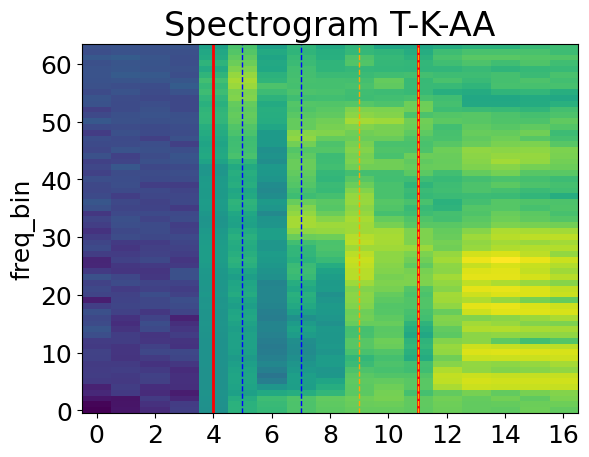

In [201]:
import random
toplotidx = random.randint(0, len(all_ori))

specgram = all_ori[toplotidx]
sp1 = all_sepframes1[toplotidx]
sp2 = all_sepframes2[toplotidx]
pt = all_phi_type[toplotidx]
sn = all_stop_names[toplotidx]
vn = all_vowel_names[toplotidx]

if pt == "ST" or pt == "D": 
    ss, se = get_sel_interval(sp1, sp2, 0.4, 0.55)
    dlineslist = [ss, se]
    dlineslist2 = []
else: 
    ss, se = get_sel_interval(sp1, sp2, 0.25, 0.3)
    ssa, sea = get_sel_interval(sp1, sp2, 0.85, 0.9)
    dlineslist = [ss, se]
    dlineslist2 = [ssa, sea]

plot_spectrogram_lined(specgram.T, title=f"Spectrogram {pt}-{sn}-{vn}", flines=[sp1, sp2], dlines=dlineslist, dlines2=dlineslist2)
plt.show()


In [94]:
def cutHid(hid, cutstart, cutend, start_offset=0, end_offset=1): 
    if cutend is None: 
        cutend = hid.shape[0]
    selstart = max(cutstart, math.floor(cutstart + (cutend - cutstart) * start_offset))
    selend = min(cutend, math.ceil(cutstart + (cutend - cutstart) * end_offset))
    # hid is (L, H)
    return hid[selstart:selend, :]

In [ ]:
import random
toplotidx = random.randint(0, len(all_ori))

specgram = all_ori[toplotidx]
sp1 = all_sepframes1[toplotidx]
sp2 = all_sepframes2[toplotidx]
pt = all_phi_type[toplotidx]
sn = all_stop_names[toplotidx]
vn = all_vowel_names[toplotidx]

if pt == "ST": 
    ss, se = get_sel_interval(sp1, sp2, 0.3, 0.45)
    dlineslist = [ss, se]
    dlineslist2 = []
else: 
    ss, se = get_sel_interval(sp1, sp2, 0.15, 0.2)
    ssa, sea = get_sel_interval(sp1, sp2, 0.85, 0.9)
    dlineslist = [ss, se]
    dlineslist2 = [ssa, sea]

# plot_spectrogram_lined(specgram.T, title=f"Spectrogram {pt}-{sn}-{vn}", flines=[sp1, sp2], dlines=dlineslist, dlines2=dlineslist2)
# plot_waveform(all_wavs[toplotidx], REC_SAMPLE_RATE, title=f"Waveform {pt}-{sn}-{vn}", 
#               flines=[frame_to_time(sp1), frame_to_time(sp2)], 
#               dlines=map(frame_to_time, dlineslist), dlines2=map(frame_to_time, dlineslist2))
# plt.show()


In [125]:
import numpy as np

In [131]:
def find_bursts(hid, threshold=0.5, start_frame=0): 
    mel_spec_dB = hid
    # Compute the mean energy across the mel bands (average over frequency)
    mean_energy = np.mean(mel_spec_dB, axis=1).squeeze()

    # Thresholding to detect plosive bursts
    threshold = mean_energy.max() - 0.01  # This is an arbitrary threshold
    plosive_frames = np.where(mean_energy > threshold)[0]
    return plosive_frames + start_frame

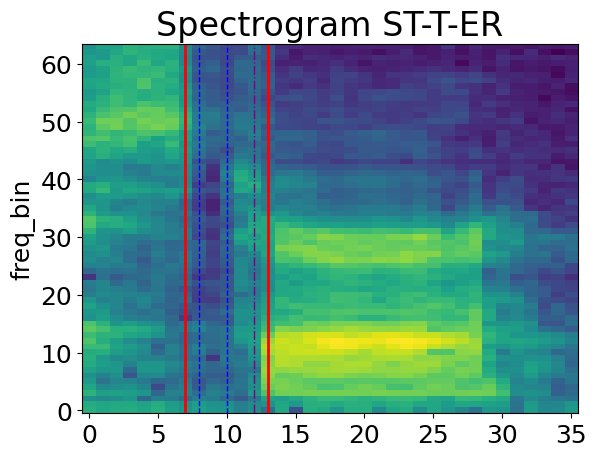

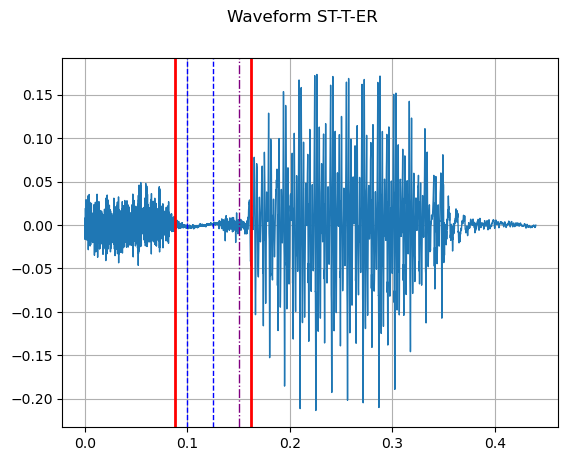

In [150]:
toplotidx = random.randint(0, len(all_ori))

specgram = all_ori[toplotidx]
sp1 = all_sepframes1[toplotidx]
sp2 = all_sepframes2[toplotidx]
pt = all_phi_type[toplotidx]
sn = all_stop_names[toplotidx]
vn = all_vowel_names[toplotidx]

if pt == "ST": 
    ss, se = get_sel_interval(sp1, sp2, 0.3, 0.45)
    dlineslist = [ss, se]
    dlineslist2 = []
else: 
    ss, se = get_sel_interval(sp1, sp2, 0.15, 0.2)
    ssa, sea = get_sel_interval(sp1, sp2, 0.85, 0.9)
    dlineslist = [ss, se]
    dlineslist2 = [ssa, sea]


plosive_frames = find_bursts(cutHid(specgram, sp1, sp2, 0, 1), start_frame=sp1)

plot_spectrogram_lined(specgram.T, title=f"Spectrogram {pt}-{sn}-{vn}", flines=[sp1, sp2], 
                       dlines=dlineslist, dlines2=dlineslist2, burstlines=plosive_frames)
plot_waveform(all_wavs[toplotidx], REC_SAMPLE_RATE, title=f"Waveform {pt}-{sn}-{vn}", 
              flines=[frame_to_time(sp1), frame_to_time(sp2)], 
              dlines=map(frame_to_time, dlineslist), dlines2=map(frame_to_time, dlineslist2), 
              burstlines=map(frame_to_time, plosive_frames))

In [151]:
import pandas as pd

In [165]:
tt_guide = pd.read_csv(os.path.join(src_, "phi-TT-guide.csv"))

In [166]:
tt_guide_out = tt_guide

In [167]:
tt_guide_out["pre"] = ""
tt_guide_out["pre_path"] = ""
tt_guide_out["pre_startTime"] = ""
tt_guide_out["pre_endTime"] = ""
tt_guide_out["phi_type"] = "TT"

In [169]:
tt_guide_out.to_csv(os.path.join(src_, "phi-TT-guide.csv"), index=False)

In [6]:
import torch
import torch.nn as nn

In [15]:
x = torch.rand(2, 5, 3)
y = torch.rand(2, 5, 3)

In [16]:
cos = nn.CosineSimilarity(dim=-1, eps=1e-6)

In [18]:
mse = nn.MSELoss(reduction="none")

In [19]:
cos(x, y).shape

torch.Size([2, 5])

In [20]:
mse(x, y).shape

torch.Size([2, 5, 3])

In [21]:
mask = torch.tensor([[1, 1, 1, 0, 0], [1, 1, 1, 1, 0]])

In [61]:
def masked_cos_1(y_hat, y, mask_noele): 
    cos = nn.CosineSimilarity(dim=-1, eps=1e-6)
    b, t, f = y_hat.shape
    mask = mask_noele.unsqueeze(-1).expand((b, t, f)).bool()
    # y_hat_masked = y_hat.masked_select(mask)
    # y_masked = y.masked_select(mask)
    y_hat_masked = y_hat * mask
    y_masked = y * mask
    # loss = torch.sum(1 - cos(y_hat_masked, y_masked)) / torch.sum(mask_noele)
    # print(y_hat, y_hat_masked)
    # loss = (1 - cos(y_hat_masked, y_masked))
    loss = torch.sum((1 - cos(y_hat_masked, y_masked)) * mask_noele) / torch.sum(mask_noele)
    return loss

def masked_cos_2(y_hat, y, mask_noele): 
    # shape of mask_noele is (B, L)
    # shape of y_hat and y is (B, L, F)
    cos = nn.CosineSimilarity(dim=-1, eps=1e-6)
    b, t, f = y_hat.shape
    print(((1 - cos(y_hat, y)) * mask_noele).shape, mask_noele.shape)
    print(torch.sum(mask_noele))
    loss = torch.sum((1 - cos(y_hat, y)) * mask_noele) / torch.sum(mask_noele)
    return loss

In [ ]:
class MaskedCosineLoss: 
    def __init__(self, loss_fn=None):
        # loss_fn is not used
        self.loss_fn = nn.CosineSimilarity(dim=-1, eps=1e-6) 

    def get_loss(self, y_hat, y, mask): 
        """
        Computes the masked loss given a loss function, predicted values, ground truth values, and a mask tensor.
        # shape of mask_noele is (B, L)
        # shape of y_hat and y is (B, L, F)
        """
        loss = torch.sum((1 - cos(y_hat, y)) * mask) / torch.sum(mask)
        return loss

In [62]:
masked_cos_1(x, y, mask), masked_cos_2(x, y, mask)

torch.Size([2, 5]) torch.Size([2, 5])
tensor(7)


(tensor(0.3234), tensor(0.3234))

: 

In [14]:
class MaskedLoss: 
    def __init__(self, loss_fn):
        self.loss_fn = loss_fn

    def get_loss(self, y_hat, y, mask): 
        """
        Computes the masked loss given a loss function, predicted values, ground truth values, and a mask tensor.
        """
        b, t, f = y_hat.shape
        mask = mask.unsqueeze(-1).expand((b, t, f)).bool()  # both y_hat and y are of same size
        # Apply mask to the predicted and ground truth values
        y_hat_masked = y_hat.masked_select(mask)
        y_masked = y.masked_select(mask)

        # Calculate the loss using the masked values
        loss = torch.sum(self.loss_fn(y_hat_masked, y_masked)) / torch.sum(mask)
        # loss = loss_fn(y_hat_masked, y_masked)
        return loss

# TEST MODEL

In [1]:
import torch.nn as nn
from torch.nn import Module
import torch
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from model_layers import LinearPack
from model_padding import mask_it
from model_attention import ScaledDotProductAttention

In [30]:
class VQEncoderV3(Module): 
    """
    20240909
    Linear + Bidirectional LSTM + Linear (merge bidirectional output)
    We use ModuleList to stack LSTM layers and allow outputting all intermediate outputs. 
    """
    def __init__(self, size_list, num_layers=1, dropout=0.5):
        # size_list = [39, 64, 16, 3]
        super(VQEncoderV3, self).__init__()
        # store params to use
        self.hiddim = size_list[3]
        self.num_layers = num_layers

        # layers
        self.lin_1 = nn.Linear(size_list[0], size_list[3])
        self.rnnlist = nn.ModuleList(
            [nn.LSTM(input_size=size_list[3], hidden_size=size_list[3],
                        batch_first=True, bidirectional=True)]
        )
        for _ in range(1, num_layers): 
            self.rnnlist.append(
                nn.LSTM(input_size=size_list[3] * 2, hidden_size=size_list[3],
                        batch_first=True, bidirectional=True)
            )
        # self.rnn = nn.LSTM(input_size=size_list[3], hidden_size=size_list[3], 
        #                    num_layers=num_layers, batch_first=True, 
        #                    dropout=dropout, bidirectional=True)
        self.lin_2 = nn.Linear(size_list[3] * 2, size_list[3])
        self.act = nn.ReLU()
        self.dropout = nn.Dropout(dropout)
        # self.softmax = nn.Softmax(-1)

    def forward(self, inputs, inputs_lens): 
        b, l, _ = inputs.size()
        d = 2 # bidirectional
        enc_x = self.lin_1(inputs) # (B, L, I0) -> (B, L, I1)
        enc_x = self.act(enc_x)
        enc_x = pack_padded_sequence(enc_x, inputs_lens, batch_first=True, enforce_sorted=False)
        # initialize h and c
        # hidden_states = [(torch.zeros(d, b, self.hiddim), torch.zeros(d, b, self.hiddim)) for _ in range(self.num_layers)]
        for i, rnn in enumerate(self.rnnlist): 
            enc_x, (hn, cn) = rnn(enc_x)    # (B, L, I1) -> (B, L, I2)
            if i < self.num_layers - 1:  # No need to apply dropout after the last layer
                enc_x, _ = pad_packed_sequence(enc_x, batch_first=True)
                enc_x = self.dropout(enc_x)
                enc_x = pack_padded_sequence(enc_x, inputs_lens, batch_first=True, enforce_sorted=False)
        # enc_x, (hn, cn) = self.rnn(enc_x)  # (B, L, I1) -> (B, L, I2)
        enc_x, _ = pad_packed_sequence(enc_x, batch_first=True)
        enc_x = self.lin_2(enc_x)   # this merges the bidirectional into one.
        return enc_x
    
    # this is only to be called during inference, so dropout is not applied. 
    def encode_and_out(self, inputs, inputs_lens): 
        b, l, _ = inputs.size()
        d = 2 # bidirectional

        outs = []
        enc_x = self.lin_1(inputs) # (B, L, I0) -> (B, L, I1)
        enc_x = self.act(enc_x)
        outs.append(enc_x)
        enc_x = pack_padded_sequence(enc_x, inputs_lens, batch_first=True, enforce_sorted=False)
        # initialize h and c
        hidden_states = [(torch.zeros(d, b, self.hiddim), torch.zeros(d, b, self.hiddim)) for _ in range(self.num_layers)]
        for i, rnn in enumerate(self.rnnlist): 
            enc_x, (hn, cn) = rnn(enc_x, hidden_states[i])    # (B, L, I1) -> (B, L, I2)
            out_enc_x, _ = pad_packed_sequence(enc_x, batch_first=True)
            outs.append(out_enc_x)
        # enc_x, (hn, cn) = self.rnn(enc_x)  # (B, L, I1) -> (B, L, I2)
        enc_x = self.lin_2(out_enc_x)   # this merges the bidirectional into one.
        return enc_x, outs # return the last output and all intermediate outputs.

In [37]:
enc = VQEncoderV3([64, 64, 16, 4], num_layers=3, dropout=0.5)

In [38]:
x = torch.rand(2, 5, 64)

In [39]:
x_hat = enc(x, [5, 4])

In [42]:
enc.eval()

VQEncoderV3(
  (lin_1): Linear(in_features=64, out_features=4, bias=True)
  (rnnlist): ModuleList(
    (0): LSTM(4, 4, batch_first=True, bidirectional=True)
    (1-2): 2 x LSTM(8, 4, batch_first=True, bidirectional=True)
  )
  (lin_2): Linear(in_features=8, out_features=4, bias=True)
  (act): ReLU()
  (dropout): Dropout(p=0.5, inplace=False)
)

In [43]:
x_hat, outs = enc.encode_and_out(x, [5, 4])

In [44]:
x_hat

tensor([[[ 0.0203, -0.1999, -0.2362, -0.3700],
         [ 0.0098, -0.2290, -0.2107, -0.3914],
         [-0.0048, -0.2525, -0.1887, -0.4016],
         [-0.0291, -0.2767, -0.1647, -0.4043],
         [-0.0749, -0.3123, -0.1301, -0.3987]],

        [[ 0.0144, -0.2047, -0.2327, -0.3689],
         [-0.0014, -0.2371, -0.2037, -0.3896],
         [-0.0273, -0.2675, -0.1744, -0.3979],
         [-0.0742, -0.3066, -0.1362, -0.3952],
         [-0.1416, -0.2582, -0.1562, -0.3031]]], grad_fn=<ViewBackward0>)

In [56]:
outs[1]

tensor([[[ 0.0312,  0.0269,  0.0499, -0.0779,  0.0766, -0.1292, -0.2503,
           0.0391],
         [ 0.0463,  0.0287,  0.0672, -0.0938,  0.0772, -0.1264, -0.2460,
           0.0413],
         [ 0.0553,  0.0303,  0.0725, -0.1003,  0.0817, -0.1229, -0.2332,
           0.0502],
         [ 0.0685,  0.0514,  0.0715, -0.1185,  0.0840, -0.1093, -0.2052,
           0.0641],
         [ 0.0692,  0.0615,  0.0679, -0.1284,  0.0625, -0.0716, -0.1469,
           0.0551]],

        [[ 0.0294,  0.0221,  0.0504, -0.0747,  0.0788, -0.1254, -0.2444,
           0.0420],
         [ 0.0526,  0.0492,  0.0649, -0.1068,  0.0802, -0.1158, -0.2334,
           0.0533],
         [ 0.0552,  0.0284,  0.0696, -0.1058,  0.0687, -0.0989, -0.2113,
           0.0490],
         [ 0.0584,  0.0419,  0.0724, -0.1054,  0.0555, -0.0682, -0.1589,
           0.0398],
         [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000]]], grad_fn=<IndexSelectBackward0>)

In [115]:
class VQDecoderV3(Module): 
    """
    注意：decoder是自回归的，因而无需bidirectional
    同时也输出attention_out
    Additionally, we output all intermediate outputs. 
    """
    def __init__(self, size_list, num_layers=1, dropout=0.5):
        # size_list = [13, 64, 16, 3]: similar to encoder, just layer 0 different
        super(VQDecoderV3, self).__init__()
        self.lin_1 = nn.Linear(size_list[0], size_list[3])
        self.rnn = nn.LSTM(input_size=size_list[3], hidden_size=size_list[3], 
                            num_layers=num_layers, batch_first=True, 
                            dropout=dropout, bidirectional=False)
        self.attention = ScaledDotProductAttention(q_in=size_list[3], kv_in=size_list[3], qk_out=size_list[3], v_out=size_list[3])
        self.lin_2 = nn.Linear(size_list[3], size_list[0])

        self.act = nn.ReLU()

        # vars
        self.num_layers = num_layers
        self.size_list = size_list

    def inits(self, batch_size, device): 
        h0 = torch.zeros((self.num_layers, batch_size, self.size_list[3]), dtype=torch.float, device=device, requires_grad=False)
        c0 = torch.zeros((self.num_layers, batch_size, self.size_list[3]), dtype=torch.float, device=device, requires_grad=False)
        hidden = (h0, c0)
        dec_in_token = torch.zeros((batch_size, 1, self.size_list[0]), dtype=torch.float, device=device, requires_grad=False)
        return hidden, dec_in_token

    def forward(self, hid_r, in_mask, init_in, hidden):
        # Attention decoder
        length = hid_r.size(1) # get length

        dec_in_token = init_in

        outputs = []
        attention_weights = []
        for t in range(length):
            dec_x = self.lin_1(dec_in_token)
            dec_x = self.act(dec_x)
            dec_x, hidden = self.rnn(dec_x, hidden)
            print(hidden[0].shape)
            dec_x, attention_weight = self.attention(dec_x, hid_r, hid_r, in_mask.unsqueeze(1))    # unsqueeze mask here for broadcast
            dec_x = self.lin_2(dec_x)
            # 这里不能detach，因为training中还要做backprop
            outputs.append(dec_x)
            attention_weights.append(attention_weight)
            # Use the current output as the next input token
            dec_in_token = dec_x

        outputs = torch.stack(outputs, dim=1)   # stack along length dim
        attention_weights = torch.stack(attention_weights, dim=1)
        outputs = outputs.squeeze(2)
        attention_weights = attention_weights.squeeze(2)
        return outputs, attention_weights
    
    def attn_forward(self, hid_r, in_mask, init_in, hidden):
        # Attention decoder
        b, length, _ = hid_r.size()

        dec_in_token = init_in

        outputs = []
        attn_outs = []
        first_lin_outs = []
        attention_weights = []
        rnn_layer_outs = []
        for t in range(length):
            dec_x = self.lin_1(dec_in_token)
            first_lin_outs.append(dec_x)  # post-lin
            dec_x = self.act(dec_x)
            dec_x, hidden = self.rnn(dec_x, hidden)
            # add in rnn outs
            rnn_layer_outs.append(hidden[0])    # post-rnn
            dec_x, attention_weight = self.attention(dec_x, hid_r, hid_r, in_mask.unsqueeze(1))    # unsqueeze mask here for broadcast
            # 我的理解是：虽然如果不clone，list里面的tensor也会跟着变
            # 但是因为这里记录的dec_x在后来都会进入网络中，网络是自带clone的，所以这里不clone也没问题
            attn_outs.append(dec_x.clone())
            dec_x = self.lin_2(dec_x)
            outputs.append(dec_x.clone())
            attention_weights.append(attention_weight.clone())
            # Use the current output as the next input token
            dec_in_token = dec_x

        outputs = torch.stack(outputs, dim=1)   # stack along length dim
        attn_outs = torch.stack(attn_outs, dim=1)
        attention_weights = torch.stack(attention_weights, dim=1)
        first_lin_outs = torch.stack(first_lin_outs, dim=1)
        rnn_layer_outs = torch.stack(rnn_layer_outs, dim=1)
        outputs = outputs.squeeze(2)
        attn_outs = attn_outs.squeeze(2)
        attention_weights = attention_weights.squeeze(2)
        first_lin_outs = first_lin_outs.squeeze(2)

        rnn_layer_outs = rnn_layer_outs.permute(0, 2, 1, 3)
        rnn_layer_outs = torch.unbind(rnn_layer_outs, 0)
        other_outs = [first_lin_outs] + rnn_layer_outs
        return outputs, attn_outs, attention_weights, other_outs

In [107]:
dec = VQDecoderV3([64, 64, 16, 4], num_layers=3, dropout=0.5)

In [108]:
inputs = torch.rand(2, 5, 4)
mask = torch.tensor([[1, 1, 1, 0, 0], [1, 1, 1, 1, 0]])

In [109]:
batch_size = inputs.size(0)
dec_hid, init_in = dec.inits(batch_size=batch_size, device=inputs.device)

ae_dec_out, ao, ae_attn_w, flo, rlo = dec.attn_forward(inputs, mask, init_in, dec_hid)

In [114]:
rlo[2].shape, flo.shape, ao.shape, ae_dec_out.shape, ae_attn_w.shape

(torch.Size([2, 5, 4]),
 torch.Size([2, 5, 4]),
 torch.Size([2, 5, 4]),
 torch.Size([2, 5, 64]),
 torch.Size([2, 5, 5]))

In [77]:
ae_dec_out.shape

torch.Size([2, 5, 64])

In [86]:
ae_dec_out.shape

torch.Size([2, 5, 64])

In [84]:
torch.unbind(ae_dec_out, 1)[0].shape

torch.Size([2, 64])